# Trabalho Prático 1
### Matéria: Introdução a Computação Visual
### Alunos: Luís Gustavo Costa da Silva, Matheus Marchesotti Dutra Ferraz
### Matrículas:

 #### *Descrição*
O objetivo do trabalho a seguir é codificar, salvar, decodificar e reconstruir certa imagem dada pelo usuário. O método de codificação usado foi o algoritmo de Huffman.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import log10
import json
import re
import struct

In [2]:
def visualize(image_matrix, title):
    plt.title(title)
    image_plot = plt.imshow(image_matrix, cmap ='Greys_r')
    plt.colorbar()
    return

In [3]:
def psnr(matrix_i, matrix_k):
    m, n = matrix_i.shape
    
    mse = 0
    for i in range(m-1):
        for j in range(n-1):
            mse = mse + (matrix_i[i][j] - matrix_k[i][j])**2
            
    mse = mse/(m*n)
    max_number = np.amax(matrix_i)
    psne = 10*log10(max_number**2 / mse)
    
    return psne

In [4]:
def compress_rate(original_image, compressed_image):
    pixels_i, pixels_j = original_image.shape
    compressed_pixels_i, compressed_pixels_j = compressed_image.shape
    
    compress_rate =  (compressed_pixels_i*compressed_pixels_j) / (pixels_i*pixels_j)
    
    return compress_rate

In [5]:
def subtract_matrix(image_matrix):
    subtract_128 = lambda i: i - 128
    vectorized_subtract_128 = np.vectorize(subtract_128)
    subtracted_image_matrix = vectorized_subtract_128(image_matrix)

    return subtracted_image_matrix

In [6]:
def add_matrix(image_matrix):
    add_128 = lambda i: i + 128
    vectorized_add_128 = np.vectorize(add_128)
    added_image_matrix = vectorized_add_128(image_matrix)

    return added_image_matrix

In [7]:
def add_padding(image_matrix):
    rows, columns = image_matrix.shape

    if(rows%8!=0):
        rows -= rows%8-8
    if(columns%8!=0):
        columns -= columns%8-8
        
    padded_image = np.zeros((rows,columns))
    padded_image[:image_matrix.shape[0],:image_matrix.shape[1]] = image_matrix
    
    return padded_image

In [8]:
def remove_padding(image_matrix):
    rows, columns = original_image.shape
    
    unpadded_image = image_matrix[:rows, :columns]
    
    return unpadded_image

In [9]:
def compress(image_matrix, quantization_table):
    padded_matrix = add_padding(image_matrix)
    codified_matrix = np.zeros(padded_matrix.shape, dtype=int)

    rows, columns = padded_matrix.shape
    
    for r in range(0, rows, 8):
        for c in range(0, columns, 8):
            submatrix = padded_matrix[r:r+8, c:c+8]

            subtracted = subtract_matrix(submatrix)

            dct = cv2.dct(subtracted)

            quantized = np.divide(dct, quantization_table)
            quantized = np.around(quantized, decimals=0)

            codified_matrix[r:r+8, c:c+8] = quantized
            
    return codified_matrix

In [10]:
class HuffmanTree():
    
    def __init__(self, root=None, left=None, right=None):
        self.root = root
        self.left = left
        self.right = right
        
    def getRight(self):
        return self.right
    
    def getLeft(self):
        return self.left
    
    def getRoot(self):
        return self.root

In [11]:
def computeHuffman(HuffmanTree, binaryString=''):
        
        if type(HuffmanTree) == str:
            return {HuffmanTree: binaryString}
        
        leftChild, rightChild = HuffmanTree.getLeft(), HuffmanTree.getRight()
        catalog = {}
        catalog.update(computeHuffman(leftChild, binaryString + '0'))
        catalog.update(computeHuffman(rightChild, binaryString + '1'))
        
        return catalog

In [12]:
def calculateFrequency(matrix):
    
    codeArray = matrix.reshape(-1)
    frequency = {}
    
    for item in codeArray:
        item = str(item)
        if item in frequency:
            frequency[item] += 1
        else:
            frequency[item] = 1
            
    for key in frequency:
        frequency[key] = float(frequency[key])/len(codeArray)
        
    frequency_sorted = sorted(frequency.items(), key=lambda pairs:pairs[1], reverse=True)
    return frequency_sorted

In [13]:
def codificate(probabilityList):
    
    while len(probabilityList) > 1:
        
        (symbol_1, probability_1) = probabilityList[-1]
        (symbol_2, probability_2) = probabilityList[-2]
        
        probabilityList = probabilityList[:-2]
        
        HuffmanRoot = HuffmanTree(None, symbol_1, symbol_2)
        probabilityList.append((HuffmanRoot, probability_1+probability_2))
        
        probabilityList = sorted(probabilityList, key=lambda pairs:pairs[1], reverse=True)
        
    huffmanCode = computeHuffman(probabilityList[0][0])
    
    return huffmanCode

In [14]:
def decompress(codified_matrix, quantization_table):
    
    decodified_image = np.zeros(codified_matrix.shape)

    rows, columns = decodified_image.shape
    for r in range(0, rows, 8):
        for c in range(0, columns, 8):
            submatrix = codified_matrix[r:r+8, c:c+8]
            submatrix = submatrix.astype(np.float64)
            
            dequantized = np.multiply(submatrix, quantization_table)

            inverse_dct = cv2.idct(dequantized)

            decodified = add_matrix(inverse_dct)
            decodified = np.around(decodified, decimals=0)

            decodified_image[r:r+8, c:c+8] = decodified

    decodified_image = remove_padding(decodified_image)
    
    if(decodified_image.min()<0):
        decodified_image -= -decodified_image.min()
    if(decodified_image.max()>255):
        decodified_image *= 255.0/decodified_image.max()
        
    decodified_image = np.around(decodified_image, decimals=0)
    decodified_image = decodified_image.astype(int)
    
    return decodified_image

Essa matriz de quantização possui resultados bons em sua tarefa, sendo comprovadamente eficiente para quantizar matrizes.

In [15]:
quantization_table_1 = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]]
)

## Carregamento da imagem
Primeiramente, se carrega a imagem e a visualiza. A imagem escolhida para testes foi a seguinte:

![Imagem de testes](https://www.datocms-assets.com/22581/1603896191-woman-relaxed-work.jpg?dpr=0.75&fit=max&fm=jpg&w=1800)



In [16]:
# load
original_image = cv2.imread('woman-relaxed-work.jpg',0)
original_image

array([[217, 217, 216, ..., 172, 171, 170],
       [218, 217, 216, ..., 176, 175, 175],
       [218, 218, 217, ..., 174, 174, 175],
       ...,
       [171, 173, 173, ..., 192, 193, 192],
       [174, 172, 173, ..., 191, 192, 192],
       [175, 169, 172, ..., 189, 191, 191]], dtype=uint8)

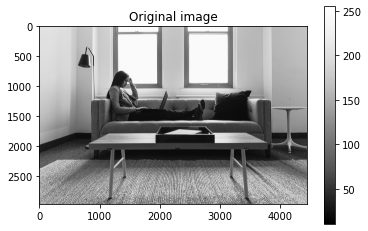

In [17]:
# visualize
visualize(original_image, "Original image")

Em seguida, se aplica a transformada do cosseno, usando a matriz de quantização inicializada anteriormente, para gerar uma matriz intermediária, que será codificada usando o algoritmo de Huffman.

In [18]:
# compress
compressed_image = compress(original_image, quantization_table_1)

In [19]:
# codificate
frequency_matrix = calculateFrequency(compressed_image)
huffman_code = codificate(frequency_matrix)

Então, usa-se a árvore gerada pela codificação para formar uma string com todos os pixels codificados.

In [20]:
codified_string = ''
for line in compressed_image:
        for key in line:
            codified_string += huffman_code[str(key)]

A imagem codificada foi salva em 2 arquivos, sendo o primeiro huffman.txt usado para salvar o dicionário da codificação de huffman, enquanto o segundo foi usado para salvar os bytes da string. Essa metodologia de 2 arquivos foi escolhida pois o dicionário e os bytes consistem em tipos de dados diferentes, impossibilitando a escrita no mesmo arquivo.

In [21]:
# save
with open('huffman.txt','w') as huffman:
    huffman.write(str(compressed_image.shape))
    huffman.write(json.dumps(huffman_code))

missing = 32-len(codified_string)%32
for i in range(missing):
    codified_string += '0'
        
with open('bytes.txt','wb') as bytes_file:
    for index in range(0, len(codified_string), 32):
        byt = int(codified_string[index:index+32][::-1], 2).to_bytes(4, 'little')
        bytes_file.write(byt)

Abre-se os arquivos salvos acima e os formata, preparando-os para uso. As chaves e valores do dicionário de huffman são trocados, assim facilitando a decodificação da string de binários.

In [22]:
#read

with open('huffman.txt', 'r') as huffman:
    data = huffman.read()
    
    match = re.search("\(.+\)", data)
    shape = match.group()
    
    data = data[len(shape):]

    shape = shape[1:-1]
    shape = shape.split(",")
    shape[0] = int(shape[0])
    shape[1] = int(shape[1])
    shape = tuple(shape)
    
    dictionary = json.loads(data)
    inverted_dictionary = {v: k for k, v in dictionary.items()}
    
read_string = ''
    
with open('bytes.txt','rb') as bytes_file:
    byte = bytes_file.read(4)
    while byte:
        integer = int.from_bytes(byte, "little")
        
        binary = "{0:b}".format(integer)        
        while(len(binary)<32):
            binary = '0' + binary
            
        read_string += binary[::-1]
        
        byte = bytes_file.read(4)

In [23]:
decodified_matrix = np.zeros(shape)

Em seguida, lê-se linearmente a string, procurando correspondência com as chaves do dicionário invertido, decodificando a string e restaurando uma matriz quantizada.

In [24]:
row = 0
column = 0

key_test = ''

for bit in range(len(read_string)):
    key_test += str(read_string[bit])
    if(key_test in inverted_dictionary.keys()):
        decodified_matrix[row, column] = inverted_dictionary[key_test]
        key_test = ''
        column += 1
        if(column==shape[1]):
            column = 0
            row +=1
            if(row==shape[0]):
                break

Visualização das matriz quantizada antes e depois da codificação:

In [25]:
print("Pré codificação:\n", compressed_image, decodified_matrix.shape)
print()
print("Pós decodificação:\n", decodified_matrix, decodified_matrix.shape)

Pré codificação:
 [[44  0  1 ...  4  0 -2]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [-2  0  0 ...  0  0  0]
 [-2  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]] (2976, 4464)

Pós decodificação:
 [[44.  0.  1. ...  4.  0. -2.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [-2.  0.  0. ...  0.  0.  0.]
 [-2.  0.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ...  0.  0.  0.]] (2976, 4464)


Aplica-se a transformada do cosseno inversa para obter a imagem reconstruida, pós codificação.

In [26]:
# decompress
decodified_image = decompress(decodified_matrix, quantization_table_1)

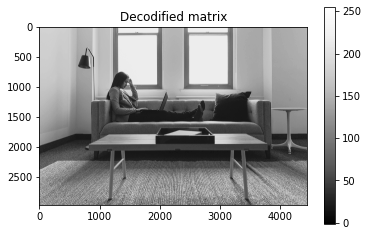

In [27]:
# visualize
visualize(decodified_image, 'Decodified matrix')

Text(0.5, 1.0, 'Decodified image')

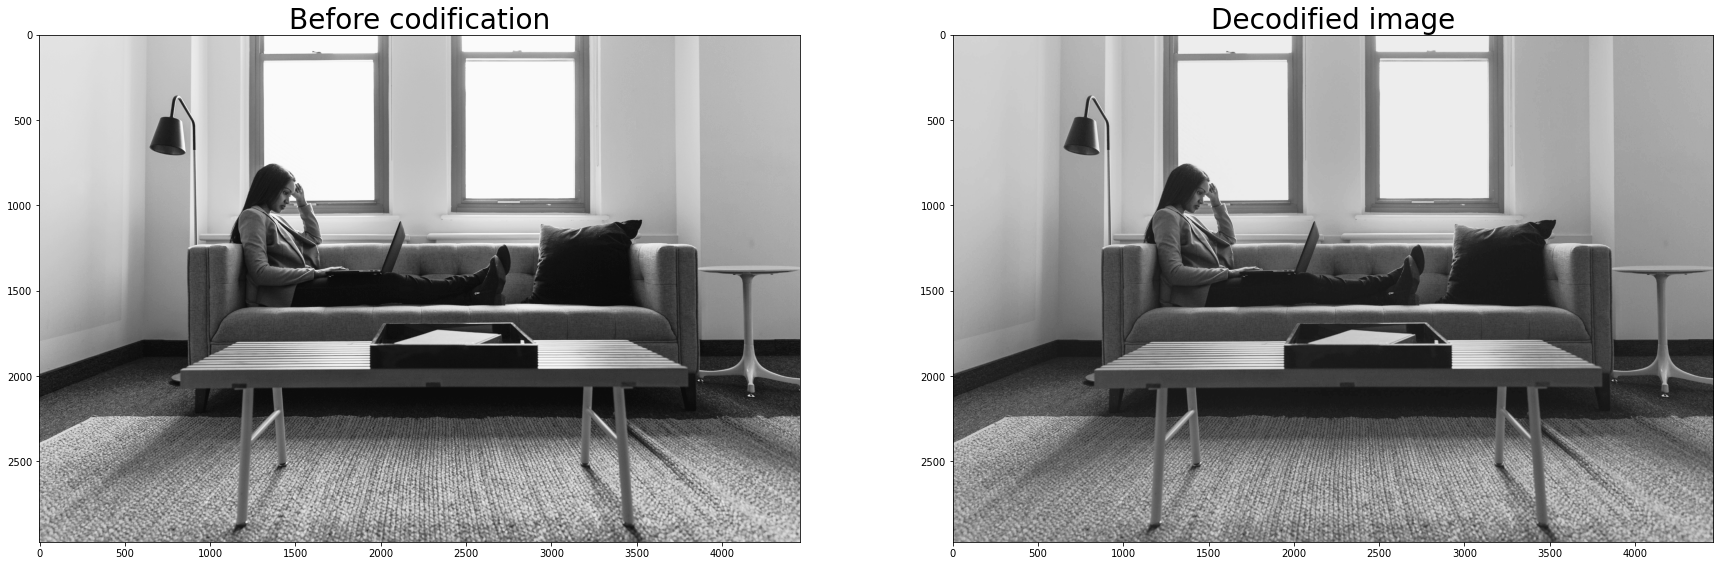

In [28]:
# final comparisson

figure = plt.figure(figsize=(30,30))

ax = figure.add_subplot(1, 2, 1)
image_plot = plt.imshow(original_image, cmap = 'Greys_r')
ax.set_title("Before codification", fontsize=28)

ax = figure.add_subplot(1, 2, 2)
image_plot = plt.imshow(decodified_image, cmap = 'Greys_r')
ax.set_title("Decodified image", fontsize=28)

In [29]:
# psnr and compress rate
psnr_result = psnr(original_image, decodified_image)
print(psnr_result)

23.52470101597204


In [45]:
original_image.dtype

dtype('uint8')

In [50]:
decodified_image = decodified_image.astype('uint8')

In [51]:
cv2.PSNR(original_image, decodified_image)

23.522382577647495

In [48]:
decodified_image.dtype

dtype('int8')